Ours, NLU Performance: [41.08037064456889, 47.19246639642902, 51.30674949832361, 54.408998361643405, 57.40269348571019]
Ours, NLG Performance: [17.019212109450805, 33.533863768678444, 41.160489035513294, 45.31340966427324, 53.36697069668155]
LLaVA, NLU Performance: [41.14101906897194, 46.5352721485106, 50.82066572883612, 53.01356414454627, 55.73622730204481]
LLaVA, NLG Performance: [11.313797787696487, 30.73937512128857, 39.0064040364836, 40.90820881040171, 45.099941781486514]
Ours, NLU Forgetting: [-1.5749453868172392, -0.31345851112553197, 0.5195464471410581, 0.3029378552637643, -0.1097237368757012]
Ours, NLG Forgetting: [-6.307005627789638, -5.821851348728896, -2.79448864738987, -3.6677663496992032, -0.9120900446341951]
LLaVA, NLU Forgetting: [-1.5142969624141718, -0.9706527590439524, 0.033462677653561146, -1.0924963618333783, -1.776189920541081]
LLaVA, NLG Forgetting: [-12.012419949543956, -8.616339996118766, -4.948573646419563, -8.072967203570736, -9.17911895982923]


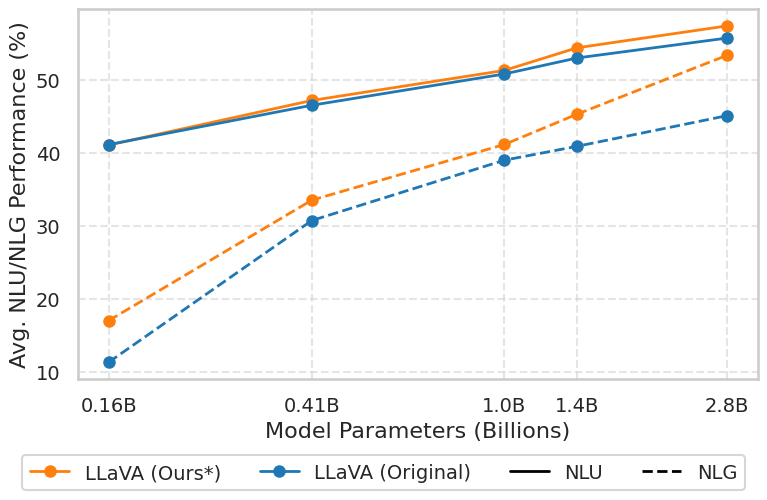

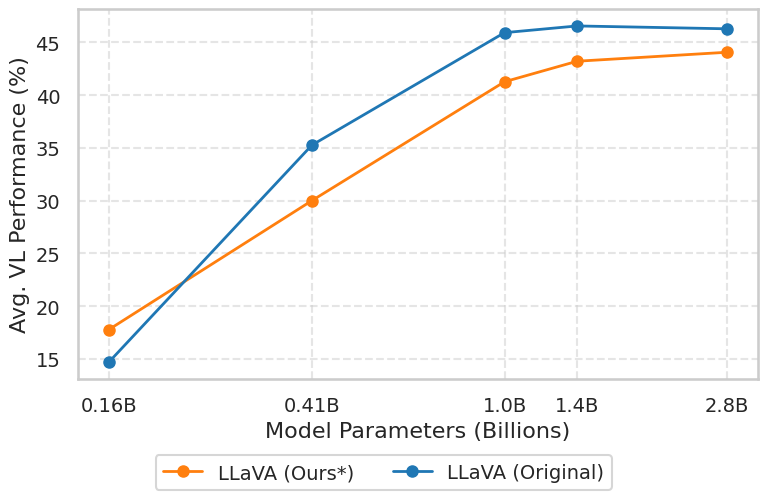

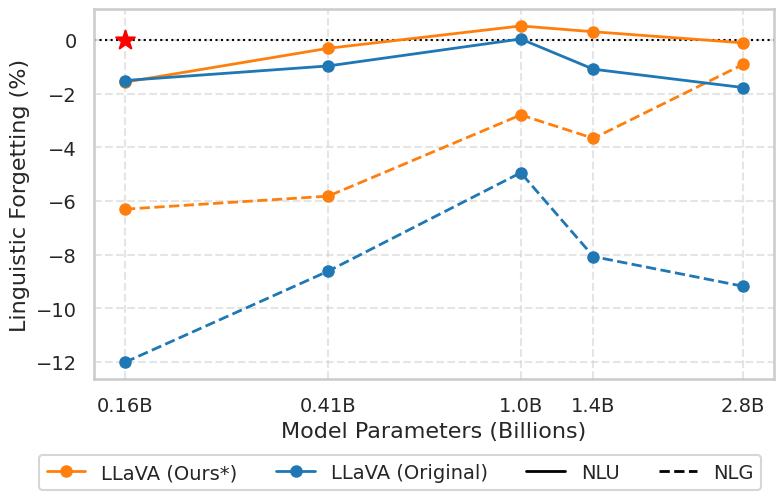

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': [8, 5],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Load the JSON data from the file
with open('results_A.json', 'r') as f:
    results = json.load(f)

# Define the filtering criteria and datasets
nlu_datasets = ["wsc273", "winogrande", "arc_easy", "arc_challenge"]
nlg_datasets = ["lambada_standard"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa"]
all_datasets = nlu_datasets + nlg_datasets + vl_datasets

# Define model scale to model name mapping
model_scale_to_name = {
    0.16: "160m",
    0.41: "410m",
    1.0: "1b",
    1.4: "1p4b",
    2.8: "2p8b"
}

# Define explicit mappings for LLaVA, Our methods, and Base LLM
llava_mapping = {
    0.16: "stage-final-llava-v15-pythia+160m",
    0.41: "stage-final-llava-v15-pythia+410m",
    1.0: "stage-final-llava-v15-pythia+1b",
    1.4: "stage-final-llava-v15-pythia+1p4b",
    2.8: "stage-final-llava-v15-pythia+2p8b"
}

our_mapping = {
    0.16: "stage-final-llava-v15-pythia+160m-soft",
    0.41: "stage-final-llava-v15-pythia+410m-soft",
    1.0: "stage-final-llava-v15-pythia+1b-soft",
    1.4: "stage-final-llava-v15-pythia+1p4b-soft",
    2.8: "stage-final-llava-v15-pythia+2p8b-soft"
}

base_llm_mapping = {
    0.16: "reproduction-align-pythia+160m",
    0.41: "reproduction-align-pythia+410m",
    1.0: "reproduction-align-pythia+1b",
    1.4: "reproduction-align-pythia+1p4b",
    2.8: "reproduction-align-pythia+2p8b"
}

# Filter and categorize models
filtered_results = {
    'our_method': {},
    'llava_method': {},
    'base_llm': {}
}

for model_name, metrics in results.items():
    if 'pythia' not in model_name:
        continue
    if model_name.startswith('cl-'):
        continue

    if model_name.endswith('soft'):
        filtered_results['our_method'][model_name] = metrics
    elif 'reproduction-align' in model_name:
        filtered_results['base_llm'][model_name] = metrics
    elif 'stage-final-llava-v15-pythia+' in model_name and 'soft' not in model_name:
        filtered_results['llava_method'][model_name] = metrics

# Calculate average performances and forgetting
def calculate_performance(metrics, datasets):
    performances = {}
    for model, data in metrics.items():
        scores = [data.get(dataset, np.nan) * 100 for dataset in datasets]
        valid_scores = [score for score in scores if not np.isnan(score)]
        performances[model] = np.mean(valid_scores) if valid_scores else np.nan
    return performances

def calculate_nlu_nlg_forgetting(our_method, base_llm, llava_method):
    nlu_forgetting = {}
    nlg_forgetting = {}
    
    for scale, our_model in our_mapping.items():
        base_model = base_llm_mapping[scale]
        
        if our_model in our_method and base_model in base_llm:
            nlu_scores = [(our_method[our_model].get(dataset, np.nan) - base_llm[base_model].get(dataset, np.nan)) * 100 for dataset in nlu_datasets]
            nlg_scores = [(our_method[our_model].get(dataset, np.nan) - base_llm[base_model].get(dataset, np.nan)) * 100 for dataset in nlg_datasets]
            
            valid_nlu_scores = [score for score in nlu_scores if not np.isnan(score)]
            valid_nlg_scores = [score for score in nlg_scores if not np.isnan(score)]
            
            nlu_forgetting[our_model] = np.mean(valid_nlu_scores) if valid_nlu_scores else np.nan
            nlg_forgetting[our_model] = np.mean(valid_nlg_scores) if valid_nlg_scores else np.nan
    
    for scale, llava_model in llava_mapping.items():
        base_model = base_llm_mapping[scale]
        
        if llava_model in llava_method and base_model in base_llm:
            nlu_scores = [(llava_method[llava_model].get(dataset, np.nan) - base_llm[base_model].get(dataset, np.nan)) * 100 for dataset in nlu_datasets]
            nlg_scores = [(llava_method[llava_model].get(dataset, np.nan) - base_llm[base_model].get(dataset, np.nan)) * 100 for dataset in nlg_datasets]
            
            valid_nlu_scores = [score for score in nlu_scores if not np.isnan(score)]
            valid_nlg_scores = [score for score in nlg_scores if not np.isnan(score)]
            
            nlu_forgetting[llava_model] = np.mean(valid_nlu_scores) if valid_nlu_scores else np.nan
            nlg_forgetting[llava_model] = np.mean(valid_nlg_scores) if valid_nlg_scores else np.nan
    
    return nlu_forgetting, nlg_forgetting

# Calculate NLU and NLG performance separately
nlu_performance_our = calculate_performance(filtered_results['our_method'], nlu_datasets)
nlg_performance_our = calculate_performance(filtered_results['our_method'], nlg_datasets)

nlu_performance_llava = calculate_performance(filtered_results['llava_method'], nlu_datasets)
nlg_performance_llava = calculate_performance(filtered_results['llava_method'], nlg_datasets)

# Calculate NLU/NLG forgetting
nlu_forgetting, nlg_forgetting = calculate_nlu_nlg_forgetting(filtered_results['our_method'], filtered_results['base_llm'], filtered_results['llava_method'])

# Combine all results for plotting
model_scales = [0.16, 0.41, 1.0, 1.4, 2.8]  # Example scales in billions

def get_performance(metric_dict, mapping, scale):
    model_name = mapping[scale]
    return metric_dict.get(model_name, np.nan)

# NLU and NLG performance for our method and LLaVA
our_nlu_performance = [get_performance(nlu_performance_our, our_mapping, scale) for scale in model_scales]
our_nlg_performance = [get_performance(nlg_performance_our, our_mapping, scale) for scale in model_scales]

llava_nlu_performance = [get_performance(nlu_performance_llava, llava_mapping, scale) for scale in model_scales]
llava_nlg_performance = [get_performance(nlg_performance_llava, llava_mapping, scale) for scale in model_scales]

# NLU/NLG forgetting performance
our_nlu_forgetting = [get_performance(nlu_forgetting, our_mapping, scale) for scale in model_scales]
our_nlg_forgetting = [get_performance(nlg_forgetting, our_mapping, scale) for scale in model_scales]
llava_nlu_forgetting = [get_performance(nlu_forgetting, llava_mapping, scale) for scale in model_scales]
llava_nlg_forgetting = [get_performance(nlg_forgetting, llava_mapping, scale) for scale in model_scales]

print(f"Ours, NLU Performance: {our_nlu_performance}")
print(f"Ours, NLG Performance: {our_nlg_performance}")
print(f"LLaVA, NLU Performance: {llava_nlu_performance}")
print(f"LLaVA, NLG Performance: {llava_nlg_performance}")
print(f"Ours, NLU Forgetting: {our_nlu_forgetting}")
print(f"Ours, NLG Forgetting: {our_nlg_forgetting}")
print(f"LLaVA, NLU Forgetting: {llava_nlu_forgetting}")
print(f"LLaVA, NLG Forgetting: {llava_nlg_forgetting}")

BOTTOM_PADDING = 0.235  # Adjust the bottom padding as needed
TOP_PADDING = 0.975  # Adjust the top padding as needed
RIGHT_PADDING = 0.965  # Adjust the right padding as needed
LEFT_PADDING = 0.115  # Adjust the left padding as needed
# Plotting the graphs
plt.figure()
plt.xscale('log')
line1, = plt.plot(model_scales, our_nlu_performance, color='#ff7f0e', marker='o', linestyle='-')
line2, = plt.plot(model_scales, our_nlg_performance, color='#ff7f0e', marker='o', linestyle='--')
line3, = plt.plot(model_scales, llava_nlu_performance, color='#1f77b4', marker='o', linestyle='-')
line4, = plt.plot(model_scales, llava_nlg_performance, color='#1f77b4', marker='o', linestyle='--')

# Create dummy lines for the legend entries for line types
dummy_nlu, = plt.plot([], [], color='black', linestyle='-', label='NLU')
dummy_nlg, = plt.plot([], [], color='black', linestyle='--', label='NLG')

plt.xticks(model_scales, ['0.16B', '0.41B', '1.0B', '1.4B', '2.8B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Avg. NLU/NLG Performance (%)')

# Combine the legends
plt.legend(handles=[line1, line3, dummy_nlu, dummy_nlg],
           labels=['LLaVA (Ours*)', 'LLaVA (Original)', 'NLU', 'NLG'], loc='upper center', bbox_to_anchor=(0.45, -0.18), ncol=4)
plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(bottom=BOTTOM_PADDING, top=TOP_PADDING, right=RIGHT_PADDING, left=LEFT_PADDING) 
plt.savefig('nlu_nlg_performance.png')

# Plot Avg. VL Performance (Our Method and LLaVA Method)
our_vl_performance = calculate_performance(filtered_results['our_method'], vl_datasets)
llava_vl_performance = calculate_performance(filtered_results['llava_method'], vl_datasets)

plt.figure()
plt.xscale('log')
plt.plot(model_scales, [get_performance(our_vl_performance, our_mapping, scale) for scale in model_scales], label='LLaVA (Ours*)', color='#ff7f0e', marker='o')
plt.plot(model_scales, [get_performance(llava_vl_performance, llava_mapping, scale) for scale in model_scales], label='LLaVA (Original)', color='#1f77b4', linestyle='-', marker='o')
plt.xticks(model_scales, ['0.16B', '0.41B', '1.0B', '1.4B', '2.8B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Avg. VL Performance (%)')
plt.legend(loc='upper center', bbox_to_anchor=(0.45, -0.18), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(bottom=BOTTOM_PADDING, top=TOP_PADDING, right=RIGHT_PADDING, left=LEFT_PADDING) 
plt.savefig('vl_performance.png')

# Plot NLU/NLG Forgetting
plt.figure()
plt.xscale('log')
line1, = plt.plot(model_scales, our_nlu_forgetting, color='#ff7f0e', marker='o', linestyle='-')
line2, = plt.plot(model_scales, our_nlg_forgetting, color='#ff7f0e', marker='o', linestyle='--')
line3, = plt.plot(model_scales, llava_nlu_forgetting, color='#1f77b4', marker='o', linestyle='-')
line4, = plt.plot(model_scales, llava_nlg_forgetting, color='#1f77b4', marker='o', linestyle='--')

# Create dummy lines for the legend entries for line types
dummy_nlu, = plt.plot([], [], color='black', linestyle='-', label='NLU')
dummy_nlg, = plt.plot([], [], color='black', linestyle='--', label='NLG')

# Highlight the 0 horizontal line
plt.axhline(0, color='black', linestyle=':', linewidth=1.5, zorder=1)
# Add a star at the location (0.16B, 0)
plt.scatter(0.16, 0, color='red', marker='*', s=200, zorder=5)

plt.xticks(model_scales, ['0.16B', '0.41B', '1.0B', '1.4B', '2.8B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Linguistic Forgetting (%)')

# Combine the legends
plt.legend(handles=[line1, line3, dummy_nlu, dummy_nlg],
           labels=['LLaVA (Ours*)', 'LLaVA (Original)', 'NLU', 'NLG'], loc='upper center', bbox_to_anchor=(0.45, -0.18), ncol=4)
plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(bottom=BOTTOM_PADDING, top=TOP_PADDING, right=RIGHT_PADDING, left=LEFT_PADDING) 
plt.savefig('nlu_nlg_forgetting.png')


SGM

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': [8, 5],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Load the JSON data from the file
with open('results_A.json', 'r') as f:
    results = json.load(f)

# Define the filtering criteria and datasets
nlu_datasets = ["wsc273", "winogrande", "arc_easy", "arc_challenge"]
nlg_datasets = ["lambada_standard"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa"]
all_datasets = nlu_datasets + nlg_datasets + vl_datasets

# Define model scale to model name mapping for 0.16 and 0.41 scales only
model_scales = [0.16, 0.41]

# Define explicit mappings for LLaVA, Our methods, and Base LLM with "sgm"
llava_mapping = {
    0.16: "stage-final-llava-v15-pythia+160m",
    0.41: "stage-final-llava-v15-pythia+410m"
}

our_mapping = {
    0.16: "stage-final-llava-v15-pythia+160m-sgm",
    0.41: "stage-final-llava-v15-pythia+410m-sgm"
}

base_llm_mapping = {
    0.16: "reproduction-align-pythia+160m",
    0.41: "reproduction-align-pythia+410m"
}

# Filter and categorize models
filtered_results = {
    'our_method': {},
    'llava_method': {},
    'base_llm': {}
}

for model_name, metrics in results.items():
    if 'pythia' not in model_name:
        continue
    if model_name.startswith('cl-'):
        continue

    if model_name.endswith('sgm'):
        filtered_results['our_method'][model_name] = metrics
    elif 'reproduction-align' in model_name:
        filtered_results['base_llm'][model_name] = metrics
    elif 'stage-final-llava-v15-pythia+' in model_name and 'sgm' not in model_name:
        filtered_results['llava_method'][model_name] = metrics

# Calculate average performances and forgetting
def calculate_performance(metrics, datasets):
    performances = {}
    for model, data in metrics.items():
        scores = [data.get(dataset, np.nan) * 100 for dataset in datasets]
        valid_scores = [score for score in scores if not np.isnan(score)]
        performances[model] = np.mean(valid_scores) if valid_scores else np.nan
    return performances

def calculate_nlu_nlg_forgetting(our_method, base_llm, llava_method):
    nlu_forgetting = {}
    nlg_forgetting = {}
    
    for scale, our_model in our_mapping.items():
        base_model = base_llm_mapping[scale]
        
        if our_model in our_method and base_model in base_llm:
            nlu_scores = [(our_method[our_model].get(dataset, np.nan) - base_llm[base_model].get(dataset, np.nan)) * 100 for dataset in nlu_datasets]
            nlg_scores = [(our_method[our_model].get(dataset, np.nan) - base_llm[base_model].get(dataset, np.nan)) * 100 for dataset in nlg_datasets]
            
            valid_nlu_scores = [score for score in nlu_scores if not np.isnan(score)]
            valid_nlg_scores = [score for score in nlg_scores if not np.isnan(score)]
            
            nlu_forgetting[our_model] = np.mean(valid_nlu_scores) if valid_nlu_scores else np.nan
            nlg_forgetting[our_model] = np.mean(valid_nlg_scores) if valid_nlg_scores else np.nan
    
    for scale, llava_model in llava_mapping.items():
        base_model = base_llm_mapping[scale]
        
        if llava_model in llava_method and base_model in base_llm:
            nlu_scores = [(llava_method[llava_model].get(dataset, np.nan) - base_llm[base_model].get(dataset, np.nan)) * 100 for dataset in nlu_datasets]
            nlg_scores = [(llava_method[llava_model].get(dataset, np.nan) - base_llm[base_model].get(dataset, np.nan)) * 100 for dataset in nlg_datasets]
            
            valid_nlu_scores = [score for score in nlu_scores if not np.isnan(score)]
            valid_nlg_scores = [score for score in nlg_scores if not np.isnan(score)]
            
            nlu_forgetting[llava_model] = np.mean(valid_nlu_scores) if valid_nlu_scores else np.nan
            nlg_forgetting[llava_model] = np.mean(valid_nlg_scores) if valid_nlg_scores else np.nan
    
    return nlu_forgetting, nlg_forgetting

# Calculate NLU and NLG performance separately
nlu_performance_our = calculate_performance(filtered_results['our_method'], nlu_datasets)
nlg_performance_our = calculate_performance(filtered_results['our_method'], nlg_datasets)

nlu_performance_llava = calculate_performance(filtered_results['llava_method'], nlu_datasets)
nlg_performance_llava = calculate_performance(filtered_results['llava_method'], nlg_datasets)

# Calculate NLU/NLG forgetting
nlu_forgetting, nlg_forgetting = calculate_nlu_nlg_forgetting(filtered_results['our_method'], filtered_results['base_llm'], filtered_results['llava_method'])

# Combine all results for plotting
def get_performance(metric_dict, mapping, scale):
    model_name = mapping[scale]
    return metric_dict.get(model_name, np.nan)

# NLU and NLG performance for our method and LLaVA
our_nlu_performance = [get_performance(nlu_performance_our, our_mapping, scale) for scale in model_scales]
our_nlg_performance = [get_performance(nlg_performance_our, our_mapping, scale) for scale in model_scales]

llava_nlu_performance = [get_performance(nlu_performance_llava, llava_mapping, scale) for scale in model_scales]
llava_nlg_performance = [get_performance(nlg_performance_llava, llava_mapping, scale) for scale in model_scales]

# NLU/NLG forgetting performance
our_nlu_forgetting = [get_performance(nlu_forgetting, our_mapping, scale) for scale in model_scales]
our_nlg_forgetting = [get_performance(nlg_forgetting, our_mapping, scale) for scale in model_scales]
llava_nlu_forgetting = [get_performance(nlu_forgetting, llava_mapping, scale) for scale in model_scales]
llava_nlg_forgetting = [get_performance(nlg_forgetting, llava_mapping, scale) for scale in model_scales]

print(f"Ours, NLU Performance: {our_nlu_performance}")
print(f"Ours, NLG Performance: {our_nlg_performance}")
print(f"LLaVA, NLU Performance: {llava_nlu_performance}")
print(f"LLaVA, NLG Performance: {llava_nlg_performance}")
print(f"Ours, NLU Forgetting: {our_nlu_forgetting}")
print(f"Ours, NLG Forgetting: {our_nlg_forgetting}")
print(f"LLaVA, NLU Forgetting: {llava_nlu_forgetting}")
print(f"LLaVA, NLG Forgetting: {llava_nlg_forgetting}")

BOTTOM_PADDING = 0.235  # Adjust the bottom padding as needed
TOP_PADDING = 0.975  # Adjust the top padding as needed
RIGHT_PADDING = 0.965  # Adjust the right padding as needed
LEFT_PADDING = 0.115  # Adjust the left padding as needed

# Plotting the graphs
plt.figure()
plt.xscale('log')
line1, = plt.plot(model_scales, our_nlu_performance, color='#ff7f0e', marker='o', linestyle='-')
line2, = plt.plot(model_scales, our_nlg_performance, color='#ff7f0e', marker='o', linestyle='--')
line3, = plt.plot(model_scales, llava_nlu_performance, color='#1f77b4', marker='o', linestyle='-')
line4, = plt.plot(model_scales, llava_nlg_performance, color='#1f77b4', marker='o', linestyle='--')

# Create dummy lines for the legend entries for line types
dummy_nlu, = plt.plot([], [], color='black', linestyle='-', label='NLU')
dummy_nlg, = plt.plot([], [], color='black', linestyle='--', label='NLG')

plt.xticks(model_scales, ['0.16B', '0.41B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Avg. NLU/NLG Performance (%)')

# Combine the legends
plt.legend(handles=[line1, line3, dummy_nlu, dummy_nlg],
           labels=['LLaVA (Ours*)', 'LLaVA (Original)', 'NLU', 'NLG'], loc='upper center', bbox_to_anchor=(0.45, -0.18), ncol=4)
plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(bottom=BOTTOM_PADDING, top=TOP_PADDING, right=RIGHT_PADDING, left=LEFT_PADDING) 
plt.savefig('nlu_nlg_performance.png')

# Plot Avg. VL Performance (Our Method and LLaVA Method)
our_vl_performance = calculate_performance(filtered_results['our_method'], vl_datasets)
llava_vl_performance = calculate_performance(filtered_results['llava_method'], vl_datasets)

plt.figure()
plt.xscale('log')
plt.plot(model_scales, [get_performance(our_vl_performance, our_mapping, scale) for scale in model_scales], label='LLaVA (Ours*)', color='#ff7f0e', marker='o')
plt.plot(model_scales, [get_performance(llava_vl_performance, llava_mapping, scale) for scale in model_scales], label='LLaVA (Original)', color='#1f77b4', linestyle='-', marker='o')
plt.xticks(model_scales, ['0.16B', '0.41B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Avg. VL Performance (%)')
plt.legend(loc='upper center', bbox_to_anchor=(0.45, -0.18), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(bottom=BOTTOM_PADDING, top=TOP_PADDING, right=RIGHT_PADDING, left=LEFT_PADDING) 
plt.savefig('vl_performance.png')

# Plot NLU/NLG Forgetting
plt.figure()
plt.xscale('log')
line1, = plt.plot(model_scales, our_nlu_forgetting, color='#ff7f0e', marker='o', linestyle='-')
line2, = plt.plot(model_scales, our_nlg_forgetting, color='#ff7f0e', marker='o', linestyle='--')
line3, = plt.plot(model_scales, llava_nlu_forgetting, color='#1f77b4', marker='o', linestyle='-')
line4, = plt.plot(model_scales, llava_nlg_forgetting, color='#1f77b4', marker='o', linestyle='--')

# Create dummy lines for the legend entries for line types
dummy_nlu, = plt.plot([], [], color='black', linestyle='-', label='NLU')
dummy_nlg, = plt.plot([], [], color='black', linestyle='--', label='NLG')

# Highlight the 0 horizontal line
plt.axhline(0, color='black', linestyle=':', linewidth=1.5, zorder=1)
# Add a star at the location (0.16B, 0)
plt.scatter(0.16, 0, color='red', marker='*', s=200, zorder=5)

plt.xticks(model_scales, ['0.16B', '0.41B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Linguistic Forgetting (%)')

# Combine the legends
plt.legend(handles=[line1, line3, dummy_nlu, dummy_nlg],
           labels=['LLaVA (Ours*)', 'LLaVA (Original)', 'NLU', 'NLG'], loc='upper center', bbox_to_anchor=(0.45, -0.18), ncol=4)
plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(bottom=BOTTOM_PADDING, top=TOP_PADDING, right=RIGHT_PADDING, left=LEFT_PADDING) 
plt.savefig('nlu_nlg_forgetting.png')
